In [96]:
import pandas as pd
import seaborn as sns
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Load countries file

In [97]:
countries = pd.read_csv("exports/countries.csv")[["ISO", "Country", "Region"]]
countries.ISO = countries.ISO.str.upper()
countries.set_index("ISO", inplace=True)
countries.head(5)

,Country,Region
ISO,,
AF,Afghanistan,Asia
AX,Åland Islands,Europe
AL,Albania,Europe
DZ,Algeria,Africa
AS,American Samoa,Oceania


In [98]:
regions = countries.Region.unique()[:-1]
regions

array(['Asia', 'Europe', 'Africa', 'Oceania', 'Americas'], dtype=object)

In [99]:
fips_to_iso = pd.read_csv("exports/fips-10-4-to-iso-country-codes.csv")
countries = countries.merge(fips_to_iso, how="left", left_index=True, right_on="ISO")
countries.drop(columns=["Name"], inplace=True)
fips_to_iso.head(5)

,FIPS,ISO,Name
0,AF,AF,Afghanistan
1,AX,-,Akrotiri
2,AL,AL,Albania
3,AG,DZ,Algeria
4,AQ,AS,American Samoa


In [100]:
european_codes  = countries[countries.Region=="Europe"].dropna()
european_codes.head(5)

,Country,Region,FIPS,ISO
2,Albania,Europe,AL,AL
5,Andorra,Europe,AN,AD
15,Austria,Europe,AU,AT
23,Belarus,Europe,BO,BY
24,Belgium,Europe,BE,BE


## Compute ratio of counts of mentions (environment/global)

In [101]:
counts_file = "exports/mentions_counts_by_state_and_day.csv"

In [102]:
def read_csv(path, states=None):
    counts = pd.read_csv(path)
    counts = counts.merge(countries[["Country", "FIPS", "Region"]], how="inner", left_on="STATE", right_on="FIPS")
    counts.dropna(inplace=True)
    counts = counts.assign(DATE=pd.to_datetime(counts[["YEAR", "MONTH", "DAY"]]))
    if states is not None:
        counts = counts[counts.STATE.isin(states)]

    counts.drop(columns=["FIPS", "YEAR", "MONTH", "DAY"], inplace=True)
    counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
    return counts

In [107]:
def heatmap(counts, key="Country", figsize=(12,12), title="Ratio of mentions (environment/global)"):
    counts = counts[counts.GLOBAL_COUNT>1000]
    counts = counts.drop(columns=["ENV_COUNT", "GLOBAL_COUNT"]).dropna()
    pivot = counts.pivot_table(values="Ratio", index=[key], columns=["DATE"], fill_value=0)
    plt.figure(figsize=figsize)
    ax = sns.heatmap(pivot, robust=False)
    ax.set_title(title)

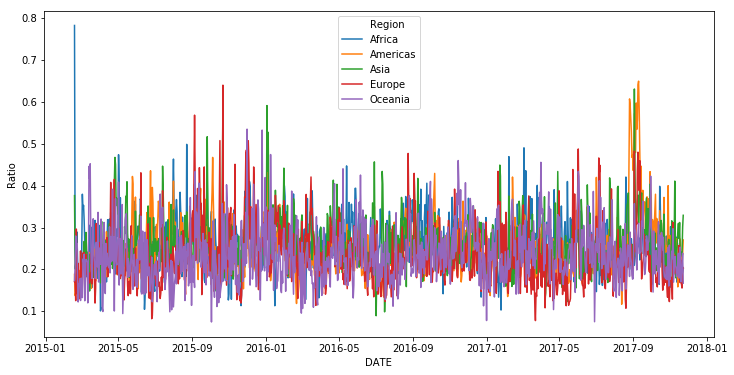

In [108]:
counts = read_csv(counts_file)
counts = counts.groupby(["Region", "DATE"]).sum()
counts = counts.reset_index()
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
plt.figure(figsize=(12, 6))
sns.lineplot(counts.DATE, counts.Ratio, hue=counts.Region)

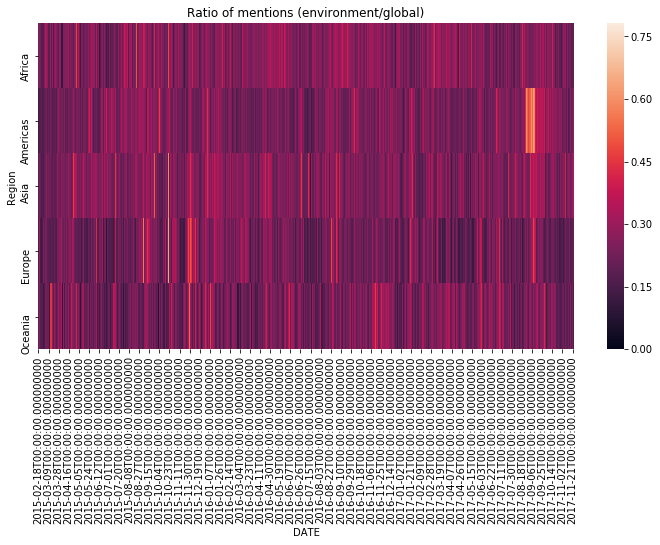

In [109]:
heatmap(counts, key="Region", figsize=(12, 6))

## By region

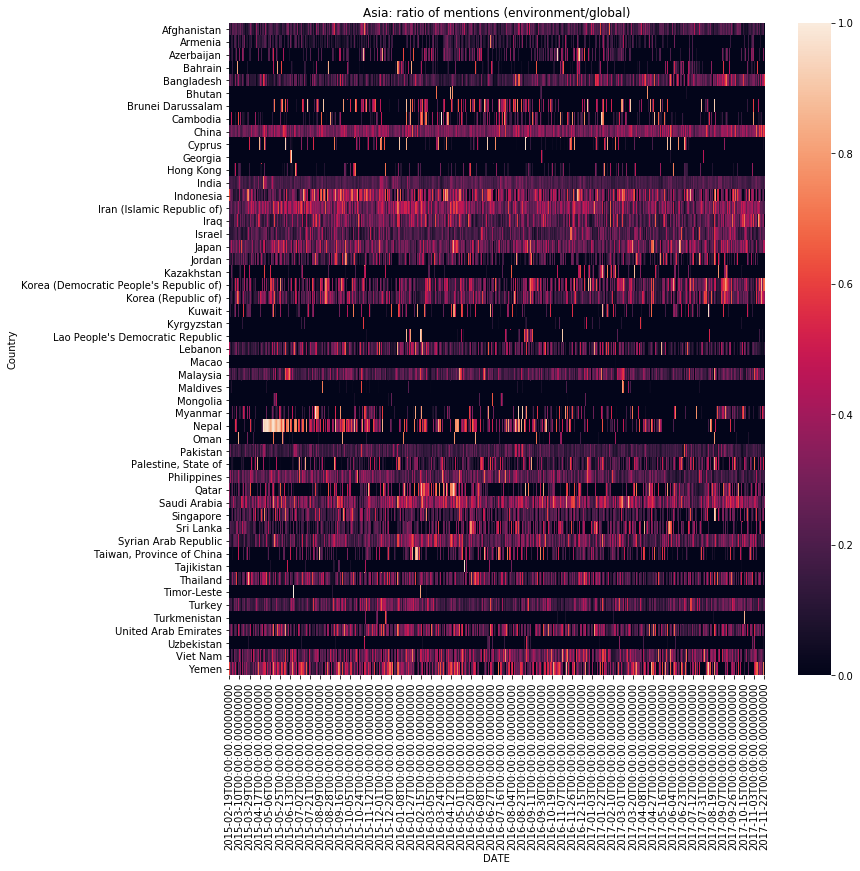

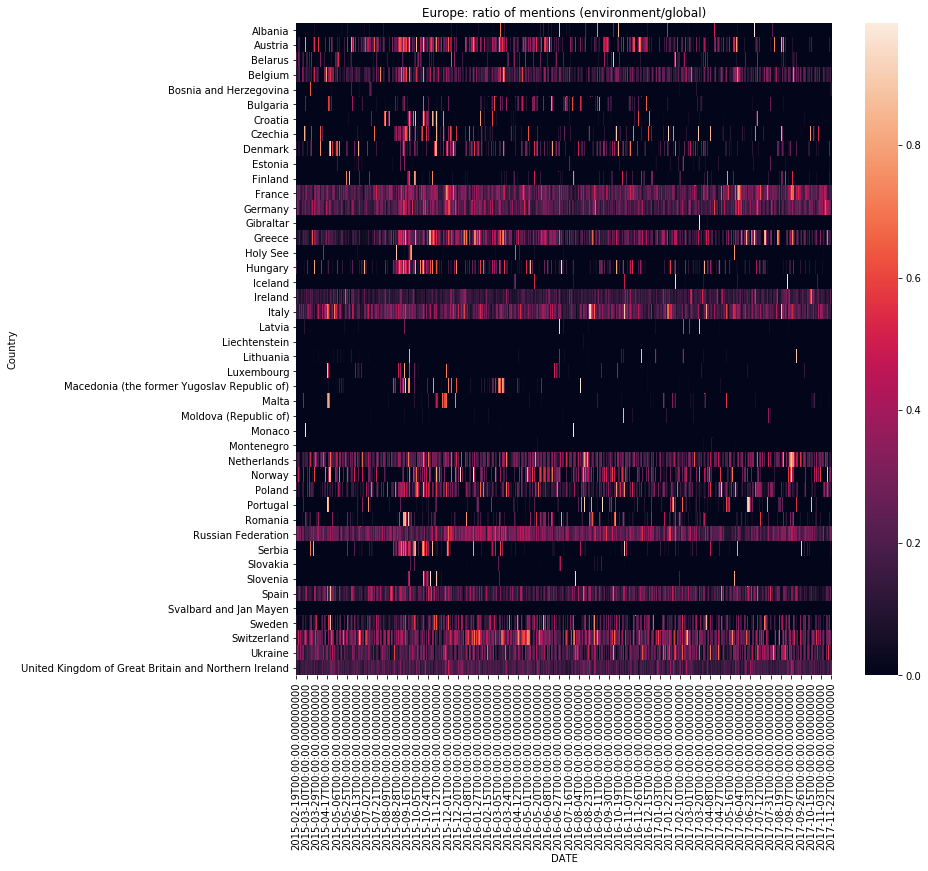

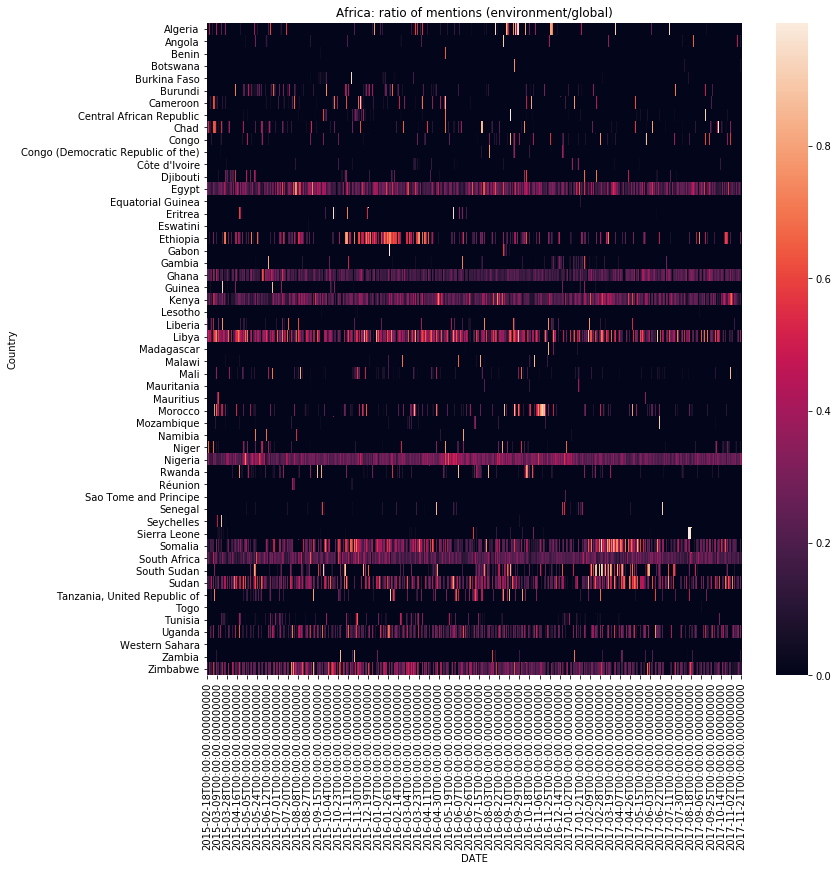

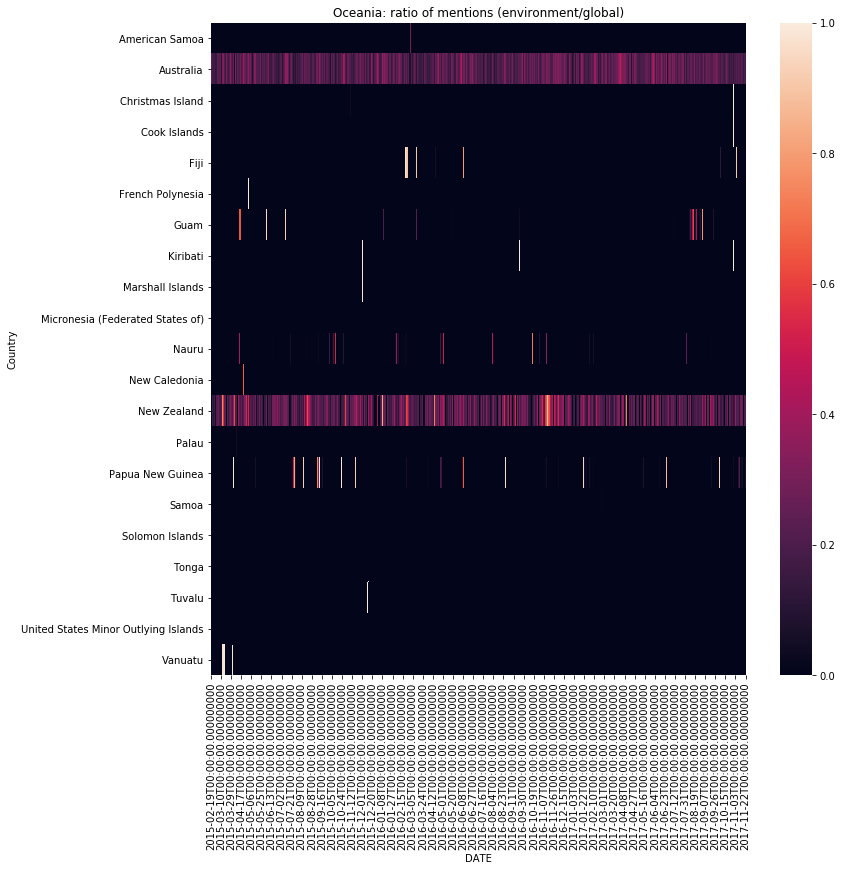

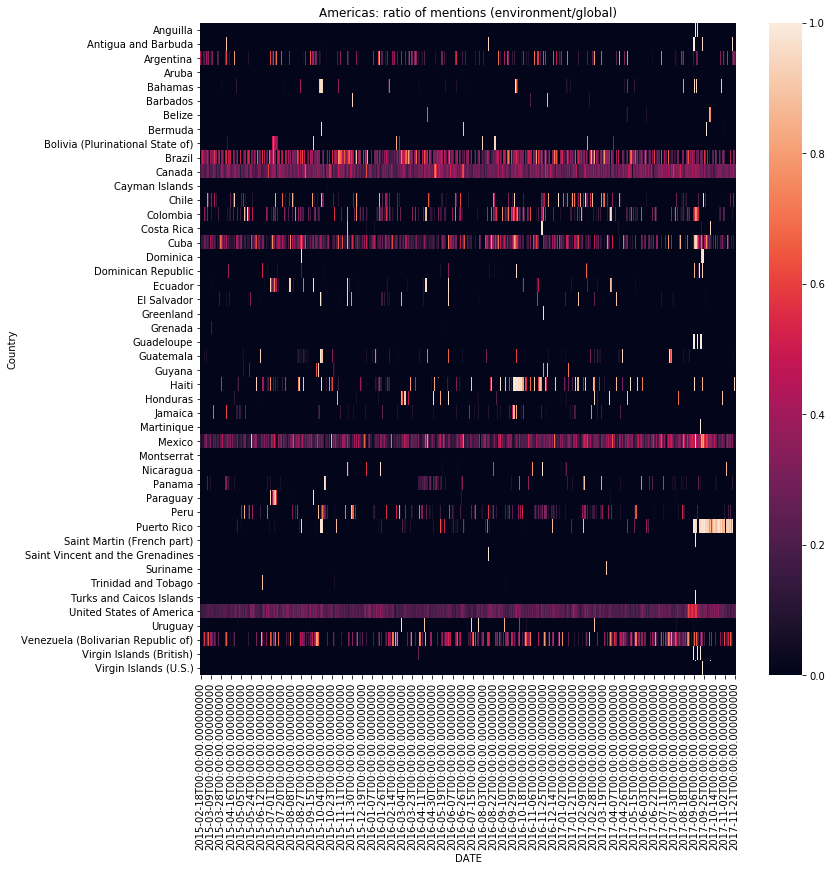

In [110]:
for region in regions:
    counts = read_csv(counts_file, countries[countries.Region==region].FIPS.values)
    heatmap(counts, key="Country", title=f"{region}: ratio of mentions (environment/global)")